Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_age, beta_sex, beta_edu, beta_income]


Output()

Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 32 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.



Model Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept    1.585  0.241   1.300    2.055      0.031    0.024      58.0   
beta_age     0.309  0.130   0.086    0.498      0.016    0.012      64.0   
beta_sex    -0.863  0.249  -1.375   -0.517      0.045    0.033      29.0   
beta_edu     0.587  0.147   0.282    0.784      0.025    0.018      43.0   
beta_income  1.029  0.146   0.832    1.318      0.018    0.013      64.0   

             ess_tail  r_hat  
intercept        61.0   1.12  
beta_age         47.0   1.25  
beta_sex         35.0   1.12  
beta_edu         61.0   1.07  
beta_income      61.0   1.11  

Top 2 most influential variables:
beta_income    1.029
beta_sex       0.863
Name: mean, dtype: float64

Selected columns: ['Venit_std', 'Sex']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_1, beta_2]


Output()

Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 30 seconds.
The number of samples is too small to check convergence reliably.


Output()

Output()

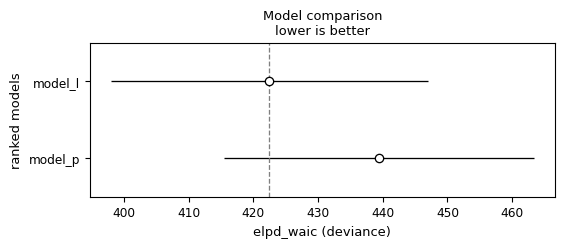


Model Comparison Results:
         rank   elpd_waic    p_waic  elpd_diff    weight         se       dse  \
model_l     0  422.454030  4.368735   0.000000  0.956394  24.478358  0.000000   
model_p     1  439.358735  2.916768  16.904705  0.043606  23.961839  9.118693   

         warning     scale  
model_l    False  deviance  
model_p    False  deviance  


In [10]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Read and prepare data
data = pd.read_csv('date_alegeri_turul2.csv')

# Standardize numerical variables
data['Varsta_std'] = (data['Varsta'] - data['Varsta'].mean()) / data['Varsta'].std()
data['Venit_std'] = (data['Venit'] - data['Venit'].mean()) / data['Venit'].std()

# First model with all variables
with pm.Model() as model_l:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    beta_income = pm.Normal('beta_income', mu=0, sigma=10)
    
    # Linear combination
    mu = intercept + \
         beta_age * data['Varsta_std'] + \
         beta_sex * data['Sex'] + \
         beta_edu * data['Educatie'] + \
         beta_income * data['Venit_std']
    
    # Likelihood
    theta = pm.math.sigmoid(mu)
    y = pm.Bernoulli('y', p=theta, observed=data['Vot'])
    
    # Sampling
    idata_l = pm.sample(draws=10, tune=10, return_inferencedata=True)

# Analyze the coefficients to find most important variables
summary = az.summary(idata_l)
print("\nModel Summary:")
print(summary)

# Get absolute mean values of coefficients (excluding intercept)
coef_importance = abs(summary.loc[['beta_age', 'beta_sex', 'beta_edu', 'beta_income'], 'mean'])
top_2_vars = coef_importance.nlargest(2)
print("\nTop 2 most influential variables:")
print(top_2_vars)

# Map variable names to data columns
var_to_col = {
    'beta_age': 'Varsta_std',
    'beta_sex': 'Sex',
    'beta_edu': 'Educatie',
    'beta_income': 'Venit_std'
}

# Get column names for top 2 variables
top_2_cols = [var_to_col[var] for var in top_2_vars.index]
print("\nSelected columns:", top_2_cols)

# Create reduced model with only the two most important variables
with pm.Model() as model_p:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=10)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=10)
    
    # Linear combination
    mu = intercept + \
         beta_1 * data[top_2_cols[0]] + \
         beta_2 * data[top_2_cols[1]]
    
    # Likelihood
    theta = pm.math.sigmoid(mu)
    y = pm.Bernoulli('y', p=theta, observed=data['Vot'])
    
    # Sampling
    idata_p = pm.sample(draws=2000, tune=1000, return_inferencedata=True)

# Compare models
with model_l:
    pm.compute_log_likelihood(idata_l)
waic_l = az.waic(idata_l, scale="deviance")

with model_p:
    pm.compute_log_likelihood(idata_p)
waic_p = az.waic(idata_p, scale="deviance")

# Compare using BB-pseudo-BMA
comparison_df = az.compare(
    {'model_l': idata_l, 'model_p': idata_p},
    method='BB-pseudo-BMA',
    ic="waic",
    scale="deviance"
)

# Plot comparison
az.plot_compare(comparison_df)
plt.show()

# Print comparison results
print("\nModel Comparison Results:")
print(comparison_df)